### О задании

В этом задании вам предстоит предсказывать год выпуска песни (**задача регрессии**) по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [ ]:
import random

import numpy as np
import pandas as pd
import torch
from torch import nn

In [ ]:
# %conda install wget

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2025-01-01 12:04:17--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘data.txt.zip’

data.txt.zip            [      <=>           ] 201.24M  37.5MB/s    in 5.6s    

2025-01-01 12:04:23 (35.9 MB/s) - ‘data.txt.zip’ saved [211011981]



In [ ]:
df = pd.read_csv("data.txt.zip", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
df.shape

(515345, 91)

## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

In [ ]:
# Сначала данные нужно отмасштабировать для того, чтобы предотвратить плохую воспроизводимость модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# Определяю модель
ridge_model = Ridge()
# А теперь найду оптимальные параметры с помощью GridSearch
param_grid = {
    'alpha': [0.1, 0.5, 1.0],
    'solver': ['auto', 'svd']
}
# GridSearch
grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid,
                           scoring='neg_mean_squared_error', cv=4)
grid_search.fit(X_train_scaled, y_train)
# получение лучших параметров и наилучшей оценки
best_params = grid_search.best_params_
best_score = np.sqrt(-grid_search.best_score_)  # RMSE
print(f'Лучшие параметры: {best_params}')
print(f'Лучший RMSE (на обучающей выборке): {best_score}')

Лучшие параметры: {'alpha': 1.0, 'solver': 'auto'}
Лучший RMSE (на обучающей выборке): 9.562566213496847


In [ ]:
# обучение модели с лучшими параметрами на всем обучающем наборе
best_ridge_model = Ridge(alpha=best_params['alpha'], solver=best_params['solver'])
best_ridge_model.fit(X_train_scaled, y_train)

# предсказания на тестовой выборке
y_pred_best_ridge = best_ridge_model.predict(X_test_scaled)

# расчет RMSE для модели с оптимальными параметрами
rmse_best_ridge = np.sqrt(mean_squared_error(y_test, y_pred_best_ridge))
print(f'RMSE для модели с оптимальными параметрами на тестовой выборке: {rmse_best_ridge}')

RMSE для модели с оптимальными параметрами на тестовой выборке: 9.510160820470436


In [ ]:
# cреднее значение целевой переменной (или константный прогноз)
constant_prediction = np.mean(y_train)
y_pred_constant = np.full(y_test.shape, constant_prediction)

In [ ]:
# рассчитаю RMSE для константного проноза
rmse_const = np.sqrt(mean_squared_error(y_test, y_pred_constant))
print(f'RMSE для константного прогноза = {rmse_const}')

RMSE для константного прогноза = 10.85246390513634


Еще один вариант

In [ ]:
df = pd.read_csv("data.txt.zip", header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903


In [ ]:
df.copy()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,...,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,...,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,...,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,...,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,...,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.66926,28.74903
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
515340,2006,51.28467,45.88068,22.19582,-5.53319,-3.61835,-16.36914,2.12652,5.18160,-8.66890,...,4.81440,-3.75991,-30.92584,26.33968,-5.03390,21.86037,-142.29410,3.42901,-41.14721,-15.46052
515341,2006,49.87870,37.93125,18.65987,-3.63581,-27.75665,-18.52988,7.76108,3.56109,-2.50351,...,32.38589,-32.75535,-61.05473,56.65182,15.29965,95.88193,-10.63242,12.96552,92.11633,10.88815
515342,2006,45.12852,12.65758,-38.72018,8.80882,-29.29985,-2.28706,-18.40424,-22.28726,-4.52429,...,-18.73598,-71.15954,-123.98443,121.26989,10.89629,34.62409,-248.61020,-6.07171,53.96319,-8.09364
515343,2006,44.16614,32.38368,-3.34971,-2.49165,-19.59278,-18.67098,8.78428,4.02039,-12.01230,...,67.16763,282.77624,-4.63677,144.00125,21.62652,-29.72432,71.47198,20.32240,14.83107,39.74909


In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [ ]:
df.shape

(515345, 91)

In [ ]:
# Сначала данные нужно отмасштабировать для того, чтобы предотвратить плохую воспроизводимость модели
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# обучение модели Ridge регрессии
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train_scaled, y_train)

# предсказания на тестовой выборке
y_pred_ridge = ridge_model.predict(X_test_scaled)

# расчет RMSE для Ridge регрессии
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
print(f'RMSE для Ridge регрессии: {rmse_ridge}')

# наилучший константный прогноз (среднее значение целевой переменной)
mean_y_train = np.mean(y_train)
y_pred_constant = np.full(y_test.shape, mean_y_train)

# Расчет RMSE для константного прогноза
rmse_constant = np.sqrt(mean_squared_error(y_test, y_pred_constant))
print(f'RMSE для наилучшего константного прогноза: {rmse_constant}')

RMSE для Ridge регрессии: 9.510160820470436
RMSE для наилучшего константного прогноза: 10.85246390513634


In [ ]:
# Вопросы:
# Правильно ли я поняла, что константный прогноз - это просто среднее значение целевой переменной?
# Когда на практике (в каких задачах) нужно считать качество при константном прогнозе? Зачем это нужно?

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Не забудьте, что для улучшения качества модели вам поможет **нормировка таргета**.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [ ]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [ ]:
train_set = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
train_loader = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

test_set = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
test_loader = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

model = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
optimizer = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
criterion = None  # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ

In [ ]:
def train(model, optimizer, criterion, train_loader, test_loader):
    """
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    raise NotImplementedError


def test(model, criterion, test_loader):
    """
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    """
    # YOUR CODE HERE (－.－)...zzzZZZzzzZZZ
    predicts = torch.ones(len(test_loader.dataset))
    return predicts

In [ ]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]


# **Задание 1**




# **SGD + Standard Scaler**


# **Попытка №1**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn            # содержит функции для реализации архитектуры нейронных сетей
import torch.nn.functional as F  # содержит различные функции активации
import torch.optim as optim # это градиентный спуск
import torch.utils.data as data_utils # большие объемы данных, которые не помещаются в оперативную память целиком (для работы с большими датасетами)

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size = 30 # размер первого скрытого слоя
hidden_size_2 = 30 # размер второго скрытого слоя
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.001

In [ ]:
# Установить seed
torch.cuda.manual_seed(42)  #  GPU

In [ ]:
torch.manual_seed(42)

In [ ]:
# функция для датасета (формирование батча данных)
def create_data_loader(X_train, y_train, X_test, y_test): # данные табличные, поэтому берем x_train, t_test и превращаем в матрицу
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor, # создает из датасета итератор
                                         batch_size=batch_size,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)
    return train_loader, test_loader

In [ ]:
# применим StandardScaler к тренировочным и тестовым данным
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
class SonarModel(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_2, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm # добавлю для отображения прогресса, это будет гораздо удобнее, чем видеть пустоту и не понимать, что происходит
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        # Прогресс-бар
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in progress_bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            progress_bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        progress_bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
# SGD - Стохастический градиентный спуск
model1 = SonarModel(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size_2, output_size=output_size) # инициальзируем и модель, и веса
# инициализирую SGD optimizer
optimizer = optim.SGD(model1.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) # SGD
# инициализирую Loss function (функцию потерь)
criterion = nn.MSELoss() #бинарная классификация
# запускаю процесс обучения
train_loss_values, valid_loss_values = run_train(model1, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 8.784860385437938, valid_loss: 8.528835622390899


EPOCH 10, train_loss: 8.70887865267579, valid_loss: 8.577831825407424


EPOCH 15, train_loss: 8.663624716383994, valid_loss: 8.44194519401777


EPOCH 20, train_loss: 8.632130050764442, valid_loss: 8.961814913419214


EPOCH 25, train_loss: 8.614054037508849, valid_loss: 8.508825325729823


EPOCH 30, train_loss: 8.594177028727584, valid_loss: 8.452848717717842


EPOCH 35, train_loss: 8.58871958324188, valid_loss: 8.433867844024507


EPOCH 40, train_loss: 8.575580404031092, valid_loss: 8.462034525257526


EPOCH 45, train_loss: 8.572866754816069, valid_loss: 8.448268191649182


EPOCH 50, train_loss: 8.564851976914648, valid_loss: 8.476096748125435


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

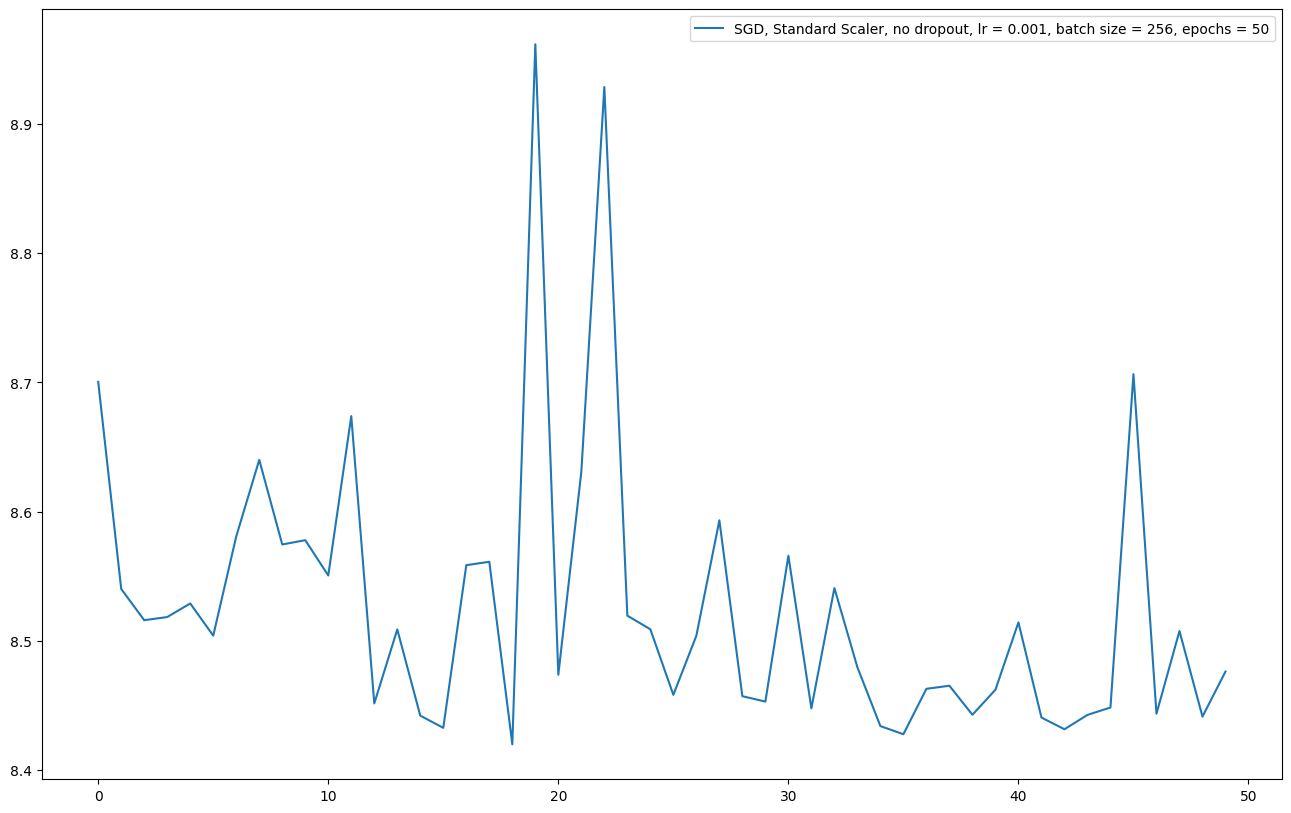

In [ ]:

plot([('SGD, Standard Scaler, no dropout, lr = 0.001, batch size = 256, epochs = 50', valid_loss_values)])


# **Попытка №1.1**

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size = 30 # размер первого скрытого слоя
hidden_size_2 = 30 # размер второго скрытого слоя
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 55 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.01

In [ ]:
# Установить seed
torch.cuda.manual_seed(42)  #  GPU

In [ ]:
#train_loader, test_loader = create_data_loader(X_train, y_train, X_test, y_test)

In [ ]:
torch.manual_seed(42)

In [ ]:
# функция для датасета (формирование батча данных)
def create_data_loader(X_train, y_train, X_test, y_test): # данные табличные, поэтому берем x_train, t_test и превращаем в матрицу
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor, # создает из датасета итератор
                                         batch_size=batch_size,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)
    return train_loader, test_loader

In [ ]:
# Стандартизирую данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
# добавлю dropout
class SonarModel1(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_2, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm # добавлю для отображения прогресса, это будет гораздо удобнее, чем видеть пустоту и не понимать, что происходит
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        # Прогресс-бар
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in progress_bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            progress_bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        progress_bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
# SGD - Стохастический градиентный спуск
model2 = SonarModel1(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size_2, output_size=output_size) # инициальзируем и модель, и веса
# инициализирую SGD optimizer
optimizer = optim.SGD(model2.parameters(), lr=learning_rate) # SGD
# инициализирую Loss function (функцию потерь)
criterion = nn.MSELoss() #бинарная классификация
# запускаю процесс обучения
train_loss_values, valid_loss_values = run_train(model2, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 180.7740143445417, valid_loss: 22.48624335185136


EPOCH 10, train_loss: 180.0526796808306, valid_loss: 15.89644978778197


EPOCH 15, train_loss: 179.3136206452157, valid_loss: 15.16114087624125


EPOCH 20, train_loss: 178.55041592326384, valid_loss: 18.10859172651083


EPOCH 25, train_loss: 177.6456934779422, valid_loss: 13.350781015830465


EPOCH 30, train_loss: 177.11550723953752, valid_loss: 26.890279599935702


EPOCH 35, train_loss: 176.2851994832357, valid_loss: 15.769245058003039


EPOCH 40, train_loss: 175.31933418593923, valid_loss: 17.553353777026185


EPOCH 45, train_loss: 174.78479931054525, valid_loss: 19.563684869520735


EPOCH 50, train_loss: 173.91198830678238, valid_loss: 15.070703501748566


EPOCH 55, train_loss: 173.08589094048304, valid_loss: 14.974342454778085


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

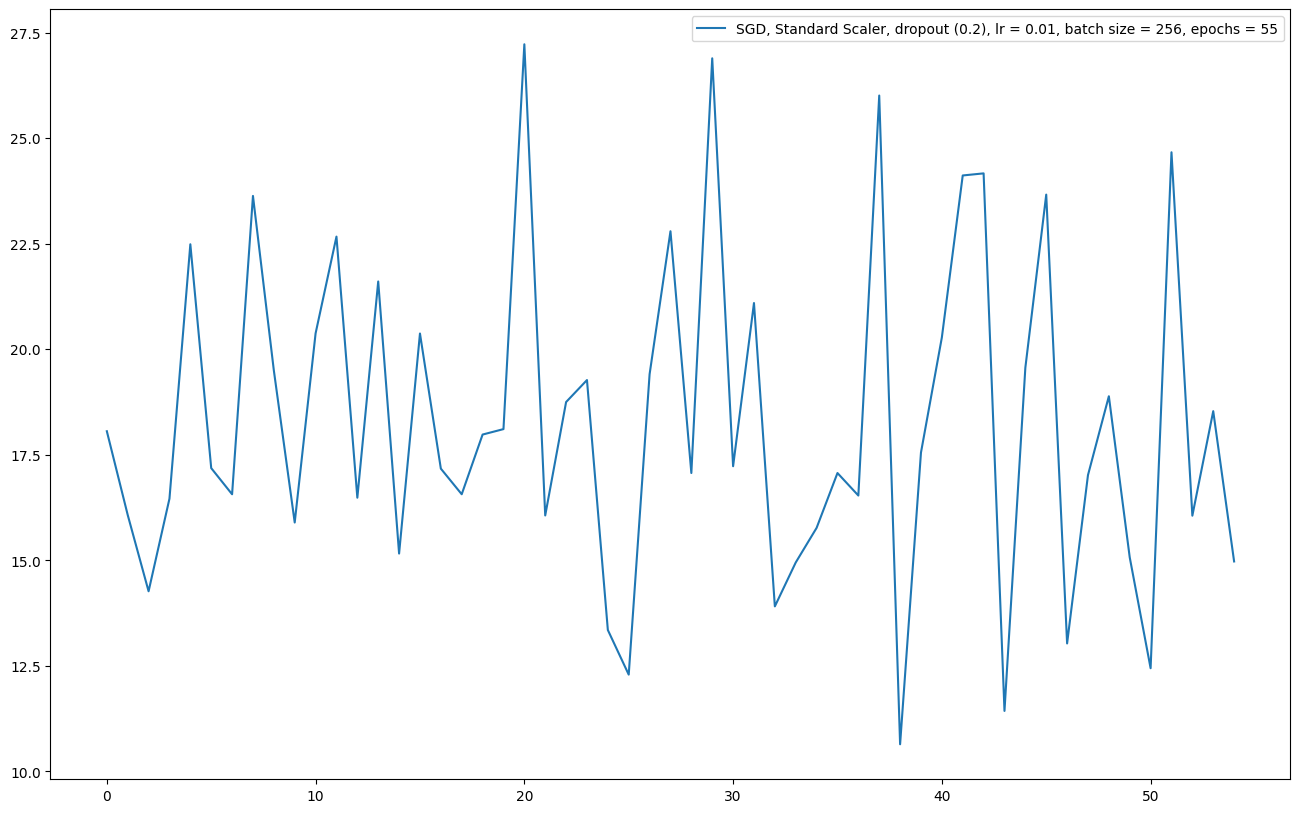

In [ ]:

plot([('SGD, Standard Scaler, dropout (0.2), lr = 0.01, batch size = 256, epochs = 55', valid_loss_values)])


# **Попытка 1.2**

# **SGD + MinMax Scaler**

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size = 30 # размер первого скрытого слоя
hidden_size_2 = 30 # размер второго скрытого слоя
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.001

In [ ]:
torch.manual_seed(42) # закончилась gpu, пусть учится на cpu

In [ ]:
# Установить seed
#torch.cuda.manual_seed(42)  #  GPU

In [ ]:
# функция для датасета (формирование батча данных)
def create_data_loader(X_train, y_train, X_test, y_test): # данные табличные, поэтому берем x_train, t_test и превращаем в матрицу
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor, # создает из датасета итератор
                                         batch_size=batch_size,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)
    return train_loader, test_loader

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
# Использую MinMaxScaler
scaler = MinMaxScaler()
# Масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train)
# Масштабируем тестовую выборку (используя параметры, обученные на обучающей выборке)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
# уберу dropout
class SonarModel3(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_2, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm # добавлю для отображения прогресса, это будет гораздо удобнее, чем видеть пустоту и не понимать, что происходит
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        # Прогресс-бар
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in progress_bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            progress_bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        progress_bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
# SGD - Стохастический градиентный спуск
model3 = SonarModel3(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size_2, output_size=output_size) # инициальзируем и модель, и веса
# инициализирую SGD optimizer
optimizer = optim.SGD(model3.parameters(), lr=learning_rate, momentum=0.9, nesterov=True) # SGD
# инициализирую Loss function (функцию потерь)
criterion = nn.MSELoss() #бинарная классификация
# запускаю процесс обучения
train_loss_values, valid_loss_values = run_train(model3, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 8.979540725943794, valid_loss: 8.948491242852542


EPOCH 10, train_loss: 8.929967459463915, valid_loss: 8.797799367715816


EPOCH 15, train_loss: 8.899714403857722, valid_loss: 8.602554569149962


EPOCH 20, train_loss: 8.899422077153693, valid_loss: 8.816795257058475


EPOCH 25, train_loss: 8.905097401694746, valid_loss: 8.712227828431837


EPOCH 30, train_loss: 8.884428761915919, valid_loss: 8.563890962317439


EPOCH 35, train_loss: 8.873804056618123, valid_loss: 8.56614087831856


EPOCH 40, train_loss: 8.86058936240131, valid_loss: 8.523388770547244


EPOCH 45, train_loss: 8.8698170485086, valid_loss: 8.590407220443877


EPOCH 50, train_loss: 8.859761294676504, valid_loss: 8.591843250954506


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

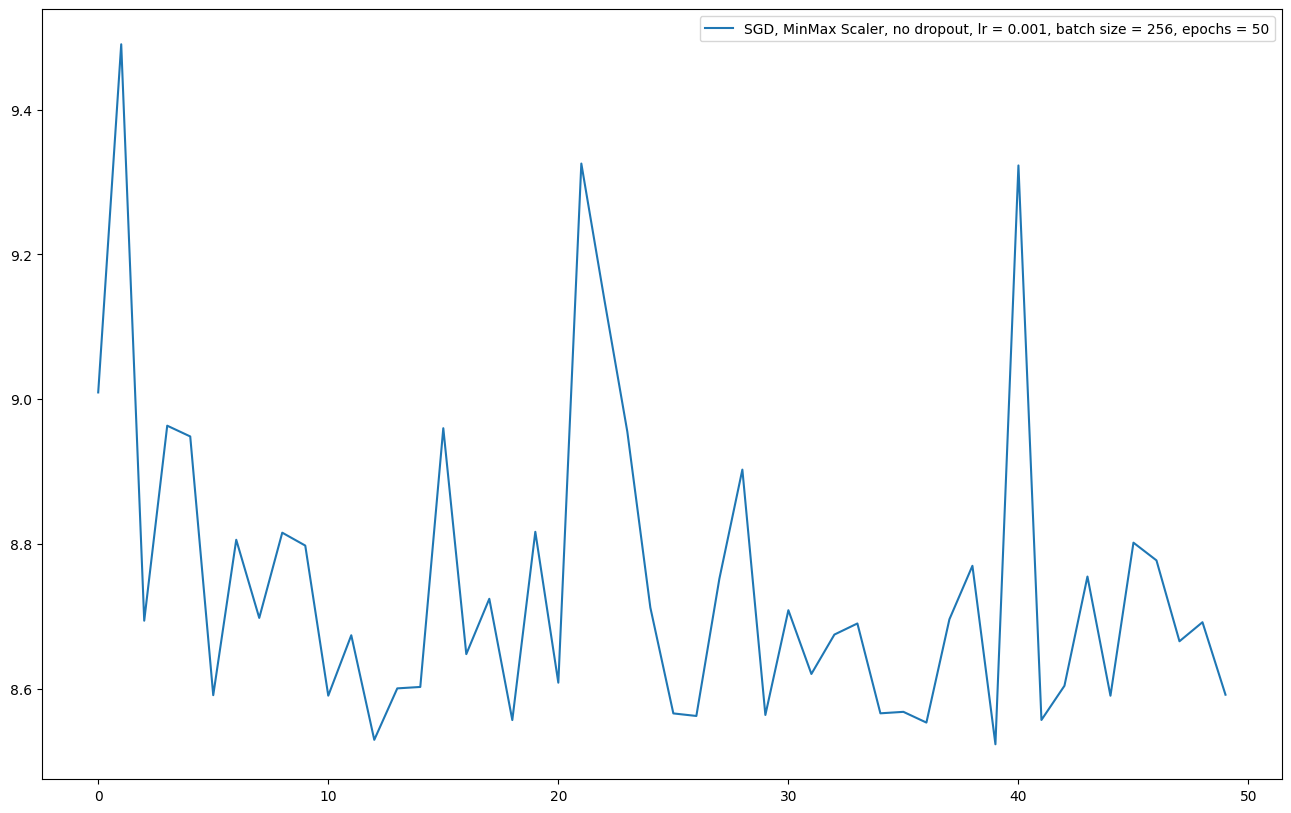

In [ ]:
plot([('SGD, MinMax Scaler, no dropout, lr = 0.001, batch size = 256, epochs = 50', valid_loss_values)])


# **Попытка №2**



# **Adam + Standard Scaler**

In [ ]:
input_size = 90 #входной слой
hidden_size = 45 # размер скрытого слоя
hidden_size_2 = 45
output_size = 1 # размер вызодного слоя
batch_size = 256 # размер матрицы, которая лежит в X
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.0001

In [ ]:
# Установить seed
torch.cuda.manual_seed(42)

In [ ]:
# функция для датасета (формирование батча данных)
def create_data_loader(X_train, y_train, X_test, y_test): # данные табличные, поэтому берем x_train, t_test и превращаем в матрицу
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor, # создает из датасета итератор
                                         batch_size=batch_size,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)
    return train_loader, test_loader

In [ ]:
# Стандартизирую данные
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
class SonarModel4(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_2, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
model4 = SonarModel4(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size_2, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.Adam(model4.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)  # Оптимизатор Adam, решила добавить eps для повышения числовой стабильности
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model4, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 1947.172679909544, valid_loss: 1937.118996195274


EPOCH 10, train_loss: 1810.826941618593, valid_loss: 1793.057140388111


EPOCH 15, train_loss: 1596.9205273087189, valid_loss: 1571.5594760403774


EPOCH 20, train_loss: 1306.6656510982555, valid_loss: 1273.4904658251469


EPOCH 25, train_loss: 940.6897707301259, valid_loss: 900.0696435305151


EPOCH 30, train_loss: 499.0969784801896, valid_loss: 451.13683281322517


EPOCH 35, train_loss: 13.555441263758846, valid_loss: 8.61400320978448


EPOCH 40, train_loss: 8.607655266525994, valid_loss: 8.56604542826662


EPOCH 45, train_loss: 8.58750732108194, valid_loss: 8.539922164218261


EPOCH 50, train_loss: 8.567155282228988, valid_loss: 8.553186862775595


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

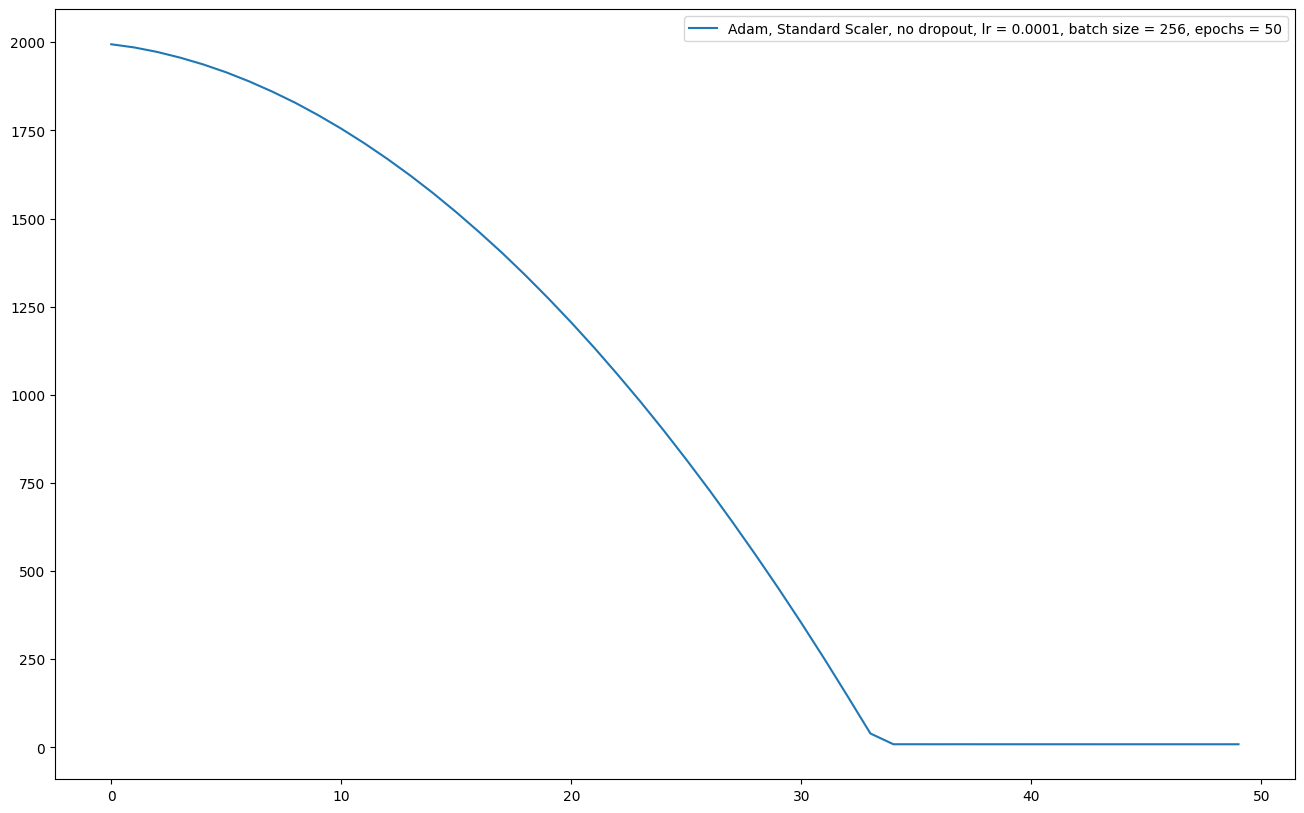

In [ ]:
plot([('Adam, Standard Scaler, no dropout, lr = 0.0001, batch size = 256, epochs = 50', valid_loss_values)])


# **Попытка №2.1**



# **Adam + MinMax Scaler**

In [ ]:
input_size = 90 #входной слой
hidden_size = 45 # размер скрытого слоя
hidden_size_2 = 45
output_size = 1 # размер вызодного слоя
batch_size = 256 # размер матрицы, которая лежит в X
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.0001

In [ ]:
# Установить seed
torch.cuda.manual_seed(42)

In [ ]:
# функция для датасета (формирование батча данных)
def create_data_loader(X_train, y_train, X_test, y_test): # данные табличные, поэтому берем x_train, t_test и превращаем в матрицу
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor, # создает из датасета итератор
                                         batch_size=batch_size,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)
    return train_loader, test_loader

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
# Использую MinMaxScaler
scaler = MinMaxScaler()
# Масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train)
# Масштабируем тестовую выборку (используя параметры, обученные на обучающей выборке)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
# уберу dropout
class SonarModel5(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_2, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
model5 = SonarModel5(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size_2, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.Adam(model5.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)  # Оптимизатор Adam, решила добавить eps для повышения числовой стабильности
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model5, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 1947.1943073735858, valid_loss: 1937.557336184058


EPOCH 10, train_loss: 1810.9737801457084, valid_loss: 1793.5198448861


EPOCH 15, train_loss: 1597.1905101245602, valid_loss: 1571.6886699412128


EPOCH 20, train_loss: 1307.0562133789062, valid_loss: 1274.8497000212717


EPOCH 25, train_loss: 941.2011184187124, valid_loss: 899.9424541209004


EPOCH 30, train_loss: 499.72663916446777, valid_loss: 450.1980143632039


EPOCH 35, train_loss: 13.911922966933934, valid_loss: 8.62714949456772


EPOCH 40, train_loss: 8.822176171980683, valid_loss: 8.722042860371051


EPOCH 45, train_loss: 8.829155609044545, valid_loss: 8.668377045357582


EPOCH 50, train_loss: 8.810142337618021, valid_loss: 8.63560423992648


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

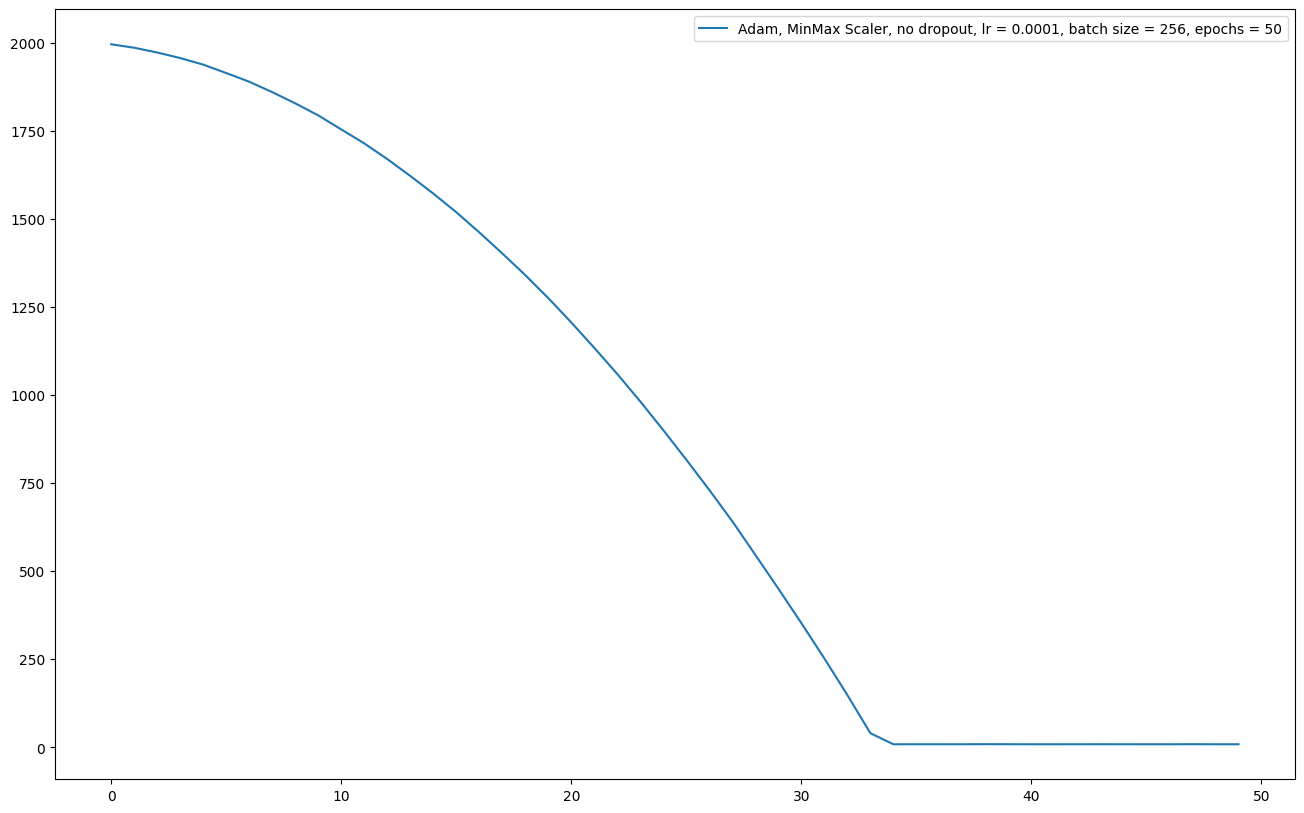

In [ ]:
plot([('Adam, MinMax Scaler, no dropout, lr = 0.0001, batch size = 256, epochs = 50', valid_loss_values)])


# **С использованием dropout**

In [ ]:
# добавлю dropout, чтобы предотвратить переобучение
# уберу dropout
class SonarModel6(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size_2, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size)
        self.act1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        self.dropout2 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_2, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
# и уберу betas
model6 = SonarModel6(input_size=input_size, hidden_size=hidden_size, hidden_size_2=hidden_size_2, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.Adam(model6.parameters(), lr=learning_rate, eps=1e-08)  # Оптимизатор Adam, решила добавить eps для повышения числовой стабильности
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model6, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 1949.4942008517435, valid_loss: 1940.262129679765


EPOCH 10, train_loss: 1815.4934556300013, valid_loss: 1798.3208116588025


EPOCH 15, train_loss: 1604.192099868067, valid_loss: 1579.4701501827428


EPOCH 20, train_loss: 1317.189851672444, valid_loss: 1284.8058719446162


EPOCH 25, train_loss: 955.9778054344733, valid_loss: 913.5368190047765


EPOCH 30, train_loss: 527.3638310211384, valid_loss: 468.2288560017501


EPOCH 35, train_loss: 155.67980733875672, valid_loss: 29.15267337194764


EPOCH 40, train_loss: 148.71883684541478, valid_loss: 15.300063940558102


EPOCH 45, train_loss: 148.6937147018399, valid_loss: 14.620462653660539


EPOCH 50, train_loss: 148.4228360973973, valid_loss: 15.928611354072496


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

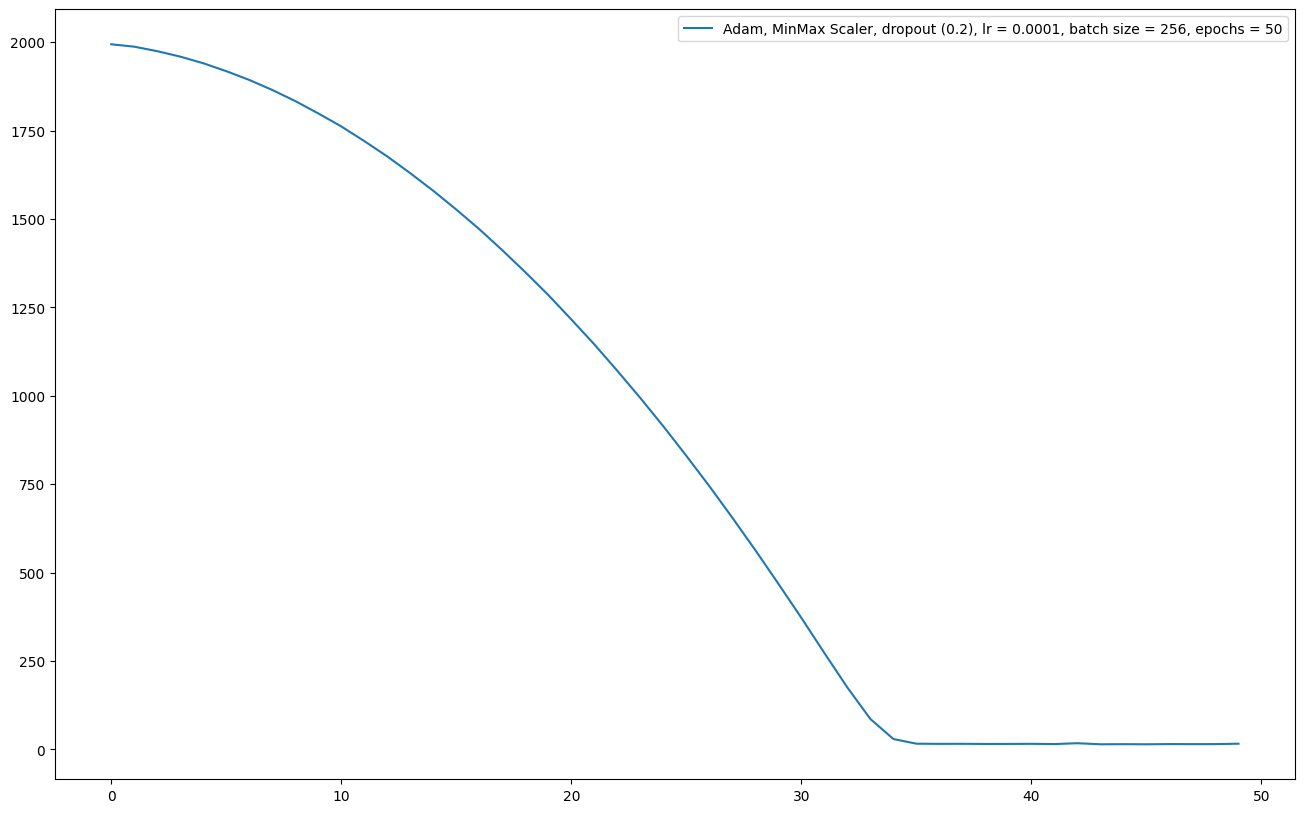

In [ ]:
plot([('Adam, MinMax Scaler, dropout (0.2), lr = 0.0001, batch size = 256, epochs = 50', valid_loss_values)])


# **Попытка №3**

**AdamW + MinMax Scaler**

In [ ]:
# Использую AdamW Optimizer, считается, что он сходится быстрее + использую еще один слой

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size_1 = 90 # размер скрытого слоя
hidden_size_2 = 30
hidden_size_3 = 30
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.0001

In [ ]:
torch.manual_seed(42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
# Использую MinMaxScaler
scaler = MinMaxScaler()
# Масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train)
# Масштабируем тестовую выборку (используя параметры, обученные на обучающей выборке)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
# Нормализация батча идет перед функцией активации
class SonarModel7(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size_1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size_1)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(in_features=hidden_size_2, out_features=hidden_size_3)
        self.batchnorm3 = nn.BatchNorm1d(hidden_size_3)
        self.act3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_3, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.batchnorm3(x)
        #x = self.dropout3(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm # добавлю для отображения прогресса, это будет гораздо удобнее, чем видеть пустоту и не понимать, что происходит
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        # Прогресс-бар
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in progress_bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            progress_bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        progress_bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
model7 = SonarModel7(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, hidden_size_3=hidden_size_3, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.AdamW(model7.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-08)  # Оптимизатор AdamW
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model7, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 1964.3869096027568, valid_loss: 1958.0984146571395


EPOCH 10, train_loss: 1875.2253130982253, valid_loss: 1864.262595601601


EPOCH 15, train_loss: 1737.5202896758158, valid_loss: 1721.746308883818


EPOCH 20, train_loss: 1553.3963026168858, valid_loss: 1532.1535565971149


EPOCH 25, train_loss: 1324.658096683999, valid_loss: 1298.7971288095607


EPOCH 30, train_loss: 1052.5046976186318, valid_loss: 1023.5305429590811


EPOCH 35, train_loss: 738.6115612510024, valid_loss: 705.3195096761873


EPOCH 40, train_loss: 383.9401650670875, valid_loss: 346.37839258779394


EPOCH 45, train_loss: 13.193852336727756, valid_loss: 8.707874295735124


EPOCH 50, train_loss: 8.670765858612313, valid_loss: 8.566180104076272


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

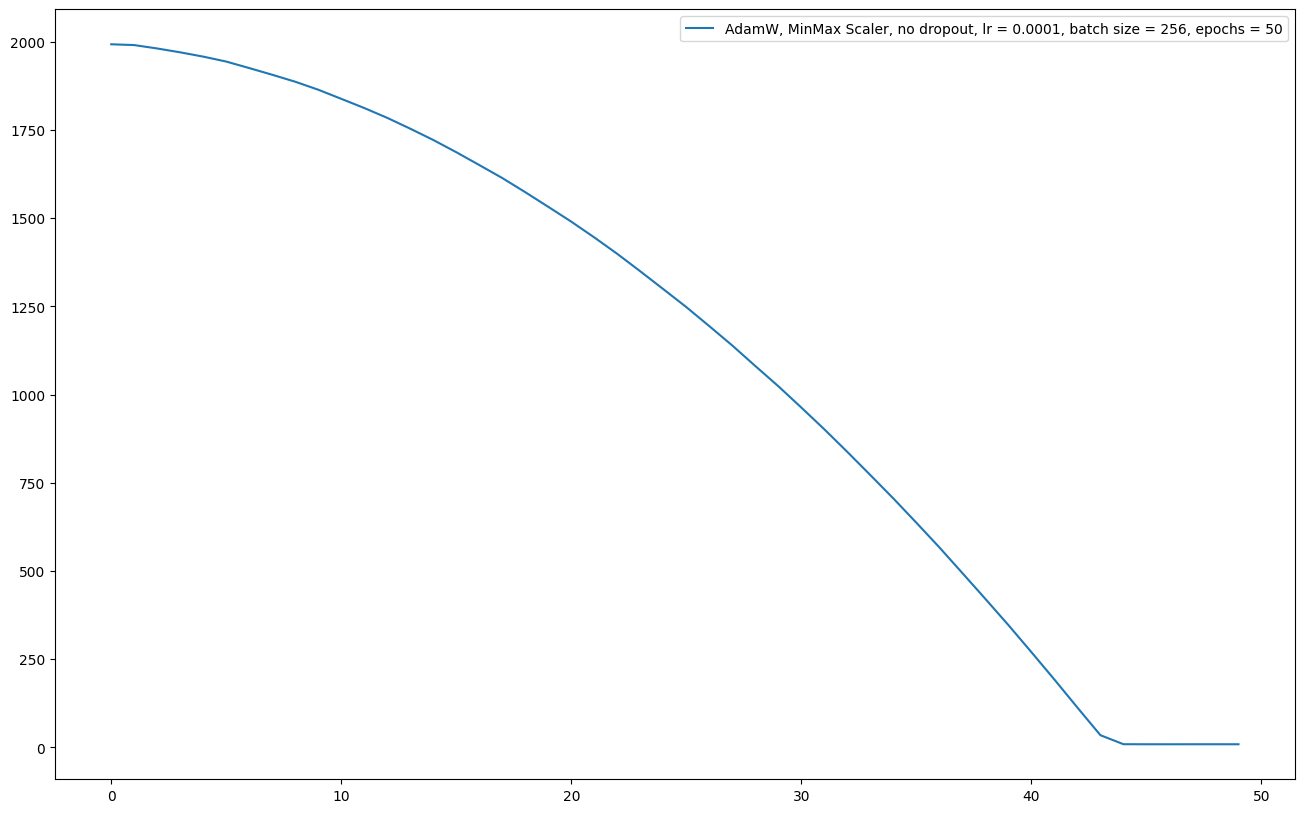

In [ ]:
plot([('AdamW, MinMax Scaler, no dropout, lr = 0.0001, batch size = 256, epochs = 50', valid_loss_values)])


# **Попытка № 3.1**


# **AdamW + Standard Scaler**

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size_1 = 90 # размер скрытого слоя
hidden_size_2 = 30
hidden_size_3 = 30
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.0001

In [ ]:
torch.manual_seed(42)

In [ ]:
# функция для датасета (формирование батча данных)
def create_data_loader(X_train, y_train, X_test, y_test): # данные табличные, поэтому берем x_train, t_test и превращаем в матрицу
    train_tensor = data_utils.TensorDataset(torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train))
    train_loader = data_utils.DataLoader(dataset=train_tensor, # создает из датасета итератор
                                         batch_size=batch_size,
                                         shuffle=True)

    test_tensor = data_utils.TensorDataset(torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test))
    test_loader = data_utils.DataLoader(dataset=test_tensor,
                                        batch_size=batch_size,
                                        shuffle=False)
    return train_loader, test_loader

In [ ]:
# Стандартизирую данные
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
train_loader, test_loader = create_data_loader(X_train_scaled, y_train, X_test_scaled, y_test)

In [ ]:
# Нормализация батча идет перед функцией активации
class SonarModel8(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size_1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size_1)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(in_features=hidden_size_2, out_features=hidden_size_3)
        self.batchnorm3 = nn.BatchNorm1d(hidden_size_3)
        self.act3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_3, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.batchnorm3(x)
        #x = self.dropout3(x)
        x = self.output(x)
        return x

In [ ]:
from tqdm import tqdm # добавлю для отображения прогресса, это будет гораздо удобнее, чем видеть пустоту и не понимать, что происходит
def run_train(model, optimizer, criterion, train_loader, test_loader, epochs, scheduler=None):
    train_loss_values = []
    valid_loss_values = []

    for epoch in range(epochs):
        model.train()
        running_loss = []

        # Прогресс-бар
        progress_bar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{epochs}', leave=False)

        for features, label in progress_bar:
            optimizer.zero_grad()

            output = model(features)
            label = label.float().unsqueeze(1)

            loss = torch.sqrt(criterion(output, label))
            loss.backward()

            optimizer.step()

            running_loss.append(loss.item())

            # Обновление прогресс-бара
            progress_bar.set_postfix(train_loss=np.mean(running_loss))

        train_loss_values.append(np.mean(running_loss))

        # Валидация
        model.eval()
        running_val_loss = []
        with torch.no_grad():
            for features, label in test_loader:
                output = model(features)
                label = label.float().unsqueeze(1)

                loss = torch.sqrt(criterion(output, label))
                running_val_loss.append(loss.item())

        valid_loss_values.append(np.mean(running_val_loss))

        # Обновление прогресс-бара с потерями
        progress_bar.set_postfix(train_loss=train_loss_values[-1], valid_loss=valid_loss_values[-1])

        # Печать потерь каждые 10 эпох
        if (epoch + 1) % 5 == 0:
            print(f'EPOCH {epoch + 1}, train_loss: {train_loss_values[-1]}, valid_loss: {valid_loss_values[-1]}')

        if scheduler is not None:
            scheduler.step()

    return train_loss_values, valid_loss_values

In [ ]:
model8 = SonarModel8(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, hidden_size_3=hidden_size_3, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.AdamW(model8.parameters(), lr=learning_rate)  # Оптимизатор AdamW
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model8, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 1964.3783484452608, valid_loss: 1957.535526691097


EPOCH 10, train_loss: 1875.2092103937077, valid_loss: 1863.5643413279315


EPOCH 15, train_loss: 1737.4971446864652, valid_loss: 1721.223822565362


EPOCH 20, train_loss: 1553.3664223374121, valid_loss: 1532.6440357170482


EPOCH 25, train_loss: 1324.6216607167494, valid_loss: 1299.4097163134281


EPOCH 30, train_loss: 1052.4614925426627, valid_loss: 1023.0351595736967


EPOCH 35, train_loss: 738.5609035534048, valid_loss: 705.0572494657913


EPOCH 40, train_loss: 383.8784548525779, valid_loss: 346.4245208135926


EPOCH 45, train_loss: 12.858777218307091, valid_loss: 8.613258000647667


EPOCH 50, train_loss: 8.27896315688329, valid_loss: 8.566023902137681


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

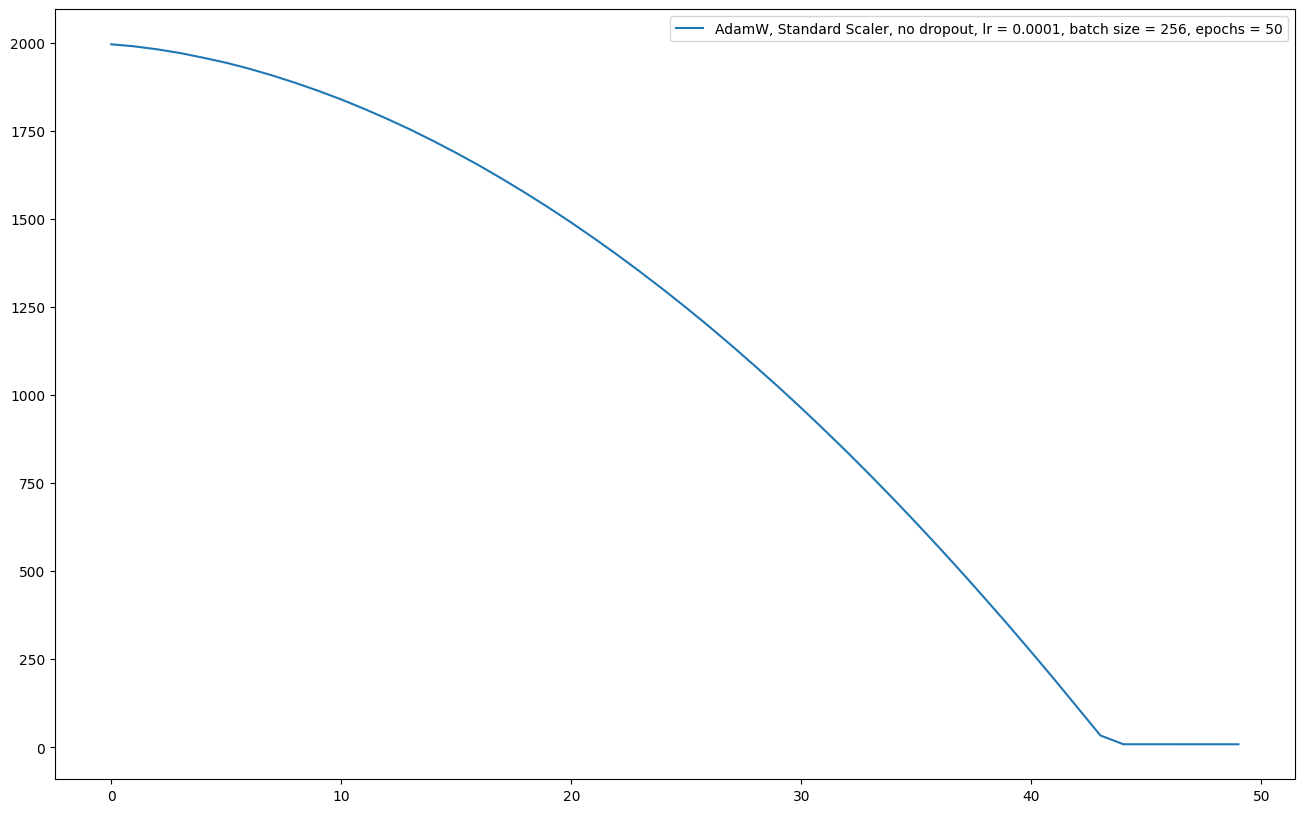

In [ ]:
plot([('AdamW, Standard Scaler, no dropout, lr = 0.0001, batch size = 256, epochs = 50', valid_loss_values)])


# **Попытка №4**

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size = 120 # размер первого скрытого слоя
#hidden_size_2 = 30 # размер второго скрытого слоя
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 100 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.001

In [ ]:
torch.cuda.manual_seed(42)

In [ ]:
class SonarModel9(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.3)
        self.layer2 = nn.Linear(in_features=hidden_size, out_features=hidden_size)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.3)
        self.output = nn.Linear(in_features=hidden_size, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        #x = self.dropout2(x)
        x = self.output(x)
        return x

In [ ]:
model9 = SonarModel9(input_size=input_size, hidden_size=hidden_size, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.Adam(model9.parameters(), lr=learning_rate)  # Оптимизатор AdamW
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model9, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 12.359336445136838, valid_loss: 11.890467882156372


EPOCH 10, train_loss: 11.776418078024657, valid_loss: 11.456705971519545


EPOCH 15, train_loss: 11.600001643561896, valid_loss: 11.167472900730548


EPOCH 20, train_loss: 11.46291029479593, valid_loss: 11.27454676486478


EPOCH 25, train_loss: 11.3676858395667, valid_loss: 11.060478009799919


EPOCH 30, train_loss: 11.303858397022777, valid_loss: 11.206769659967705


EPOCH 35, train_loss: 11.215070781328821, valid_loss: 10.831117254672664


EPOCH 40, train_loss: 11.149541435915376, valid_loss: 10.802777493354117


EPOCH 45, train_loss: 11.087770957294152, valid_loss: 10.799289125027043


EPOCH 50, train_loss: 11.036816601195346, valid_loss: 10.614874582479496


EPOCH 55, train_loss: 10.977607782839677, valid_loss: 10.545459251592655


EPOCH 60, train_loss: 10.879353212731301, valid_loss: 10.525435298976332


EPOCH 65, train_loss: 10.761143424389905, valid_loss: 10.765599222466497


EPOCH 70, train_loss: 10.682807783943664, valid_loss: 10.36858607046675


EPOCH 75, train_loss: 10.610294686511127, valid_loss: 10.342503467408738


EPOCH 80, train_loss: 10.558266312344449, valid_loss: 10.423401898676806


EPOCH 85, train_loss: 10.48021882154031, valid_loss: 10.316679267600032


EPOCH 90, train_loss: 10.448280762099799, valid_loss: 10.701326745571476


EPOCH 95, train_loss: 10.359137522200612, valid_loss: 10.004674408695486


EPOCH 100, train_loss: 10.301590940020732, valid_loss: 9.951478493095625


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

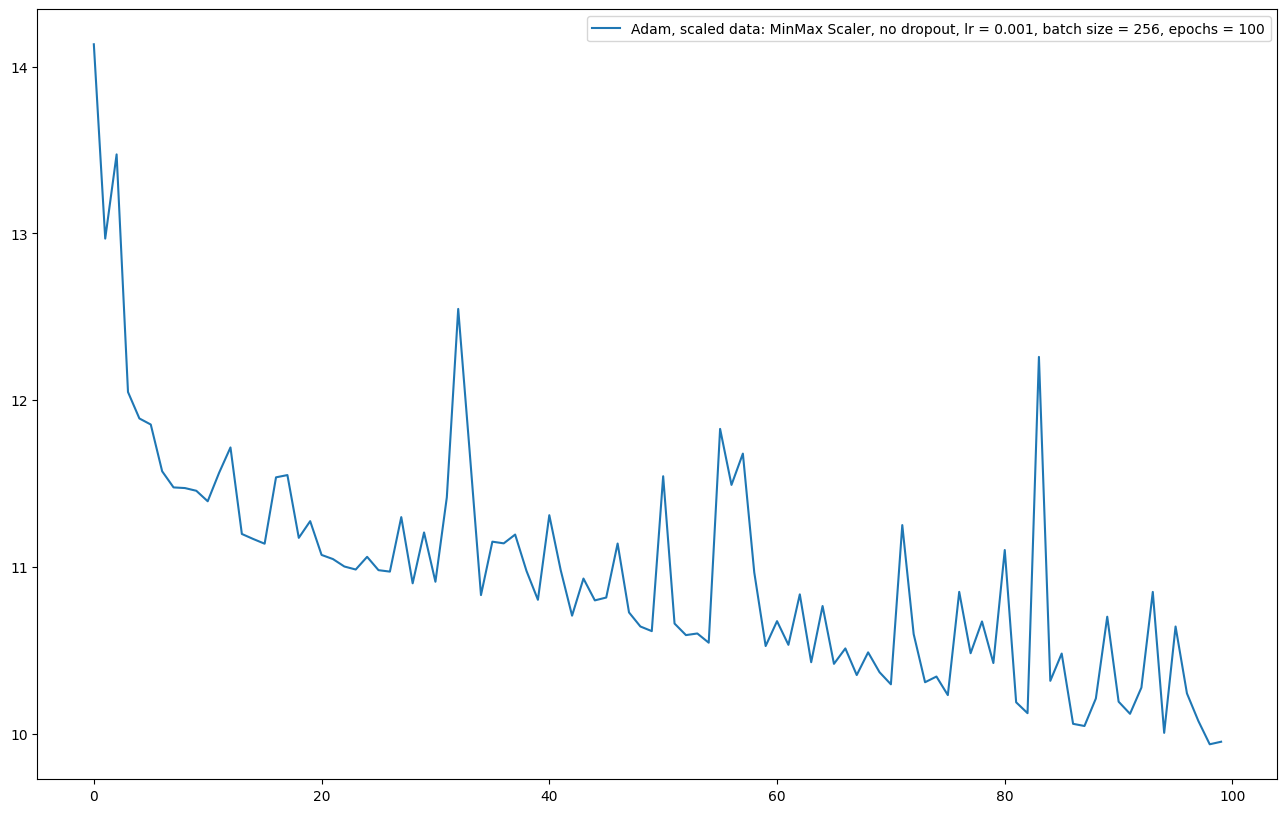

In [ ]:
plot([('Adam, scaled data: MinMax Scaler, no dropout, lr = 0.001, batch size = 256, epochs = 100', valid_loss_values)])


# **Попытка 5**

In [ ]:
# На третьей попытке мне надоело копировать код, единственное, что я поменяла , - это поставила печать потерь каждые 3 эпохи
input_size = 90 #входной слой
hidden_size_1 = 90
hidden_size_2 = 30 # размер первого скрытого слоя
hidden_size_3 = 30 # размер второго скрытого слоя
output_size = 1 # размер вызодного слоя
batch_size = 256 # установлю значение по рекомендованным
epochs = 50 #сколько раз мы прогоним нашу модель за все обучение
learning_rate = 0.0001

In [ ]:
torch.cuda.manual_seed(42)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
# Использую MinMaxScaler
scaler = MinMaxScaler()
# Масштабируем обучающую выборку
X_train_scaled = scaler.fit_transform(X_train)
# Масштабируем тестовую выборку (используя параметры, обученные на обучающей выборке)
X_test_scaled = scaler.transform(X_test)

In [ ]:
# В этот раз нормализую батч и опять поставлю dropout
# Нормализация батча идет перед функцией активации
class SonarModel10(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, output_size):
        super().__init__()
        self.layer1 = nn.Linear(in_features=input_size, out_features=hidden_size_1)
        self.batchnorm1 = nn.BatchNorm1d(hidden_size_1)
        self.act1 = nn.ReLU()
        #self.dropout1 = nn.Dropout(0.2)
        self.layer2 = nn.Linear(in_features=hidden_size_1, out_features=hidden_size_2)
        self.batchnorm2 = nn.BatchNorm1d(hidden_size_2)
        self.act2 = nn.ReLU()
        #self.dropout2 = nn.Dropout(0.2)
        self.layer3 = nn.Linear(in_features=hidden_size_2, out_features=hidden_size_3)
        self.batchnorm3 = nn.BatchNorm1d(hidden_size_3)
        self.act3 = nn.ReLU()
        #self.dropout3 = nn.Dropout(0.2)
        self.output = nn.Linear(in_features=hidden_size_3, out_features=output_size)

    def forward(self, x):
        x = self.act1(self.layer1(x))
        x = self.batchnorm1(x)
        #x = self.dropout1(x)
        x = self.act2(self.layer2(x))
        x = self.batchnorm2(x)
        #x = self.dropout2(x)
        x = self.act3(self.layer3(x))
        x = self.batchnorm3(x)
        #x = self.dropout3(x)
        x = self.output(x)
        return x

In [ ]:
model10 = SonarModel10(input_size=input_size, hidden_size_1=hidden_size_1, hidden_size_2=hidden_size_2, hidden_size_3=hidden_size_3, output_size=output_size)  # Инициализируем модель
optimizer = torch.optim.AdamW(model10.parameters(), lr=learning_rate)  # Оптимизатор Adam
criterion = nn.MSELoss()
train_loss_values, valid_loss_values = run_train(model10, optimizer=optimizer, criterion=criterion, train_loader=train_loader, test_loader=test_loader, epochs=epochs)

EPOCH 5, train_loss: 1964.38690832277, valid_loss: 1957.6546086981746


EPOCH 10, train_loss: 1875.2254051225339, valid_loss: 1863.829724000232


EPOCH 15, train_loss: 1737.5204919137175, valid_loss: 1722.1096064501469


EPOCH 20, train_loss: 1553.3964892928436, valid_loss: 1533.0563185285814


EPOCH 25, train_loss: 1324.6585009576995, valid_loss: 1299.2745083346226


EPOCH 30, train_loss: 1052.5052262531474, valid_loss: 1023.5137628234259


EPOCH 35, train_loss: 738.6120104589736, valid_loss: 705.6946389982015


EPOCH 40, train_loss: 383.940959905157, valid_loss: 346.6424303715772


EPOCH 45, train_loss: 13.206846294287288, valid_loss: 9.04305370963446


EPOCH 50, train_loss: 8.667202356898494, valid_loss: 8.59967595043749


In [ ]:
def plot(histories):
  plt.figure(figsize=(16,10))
  for name, val_loss in histories:
    plt.plot(val_loss, label=name)
  plt.legend()

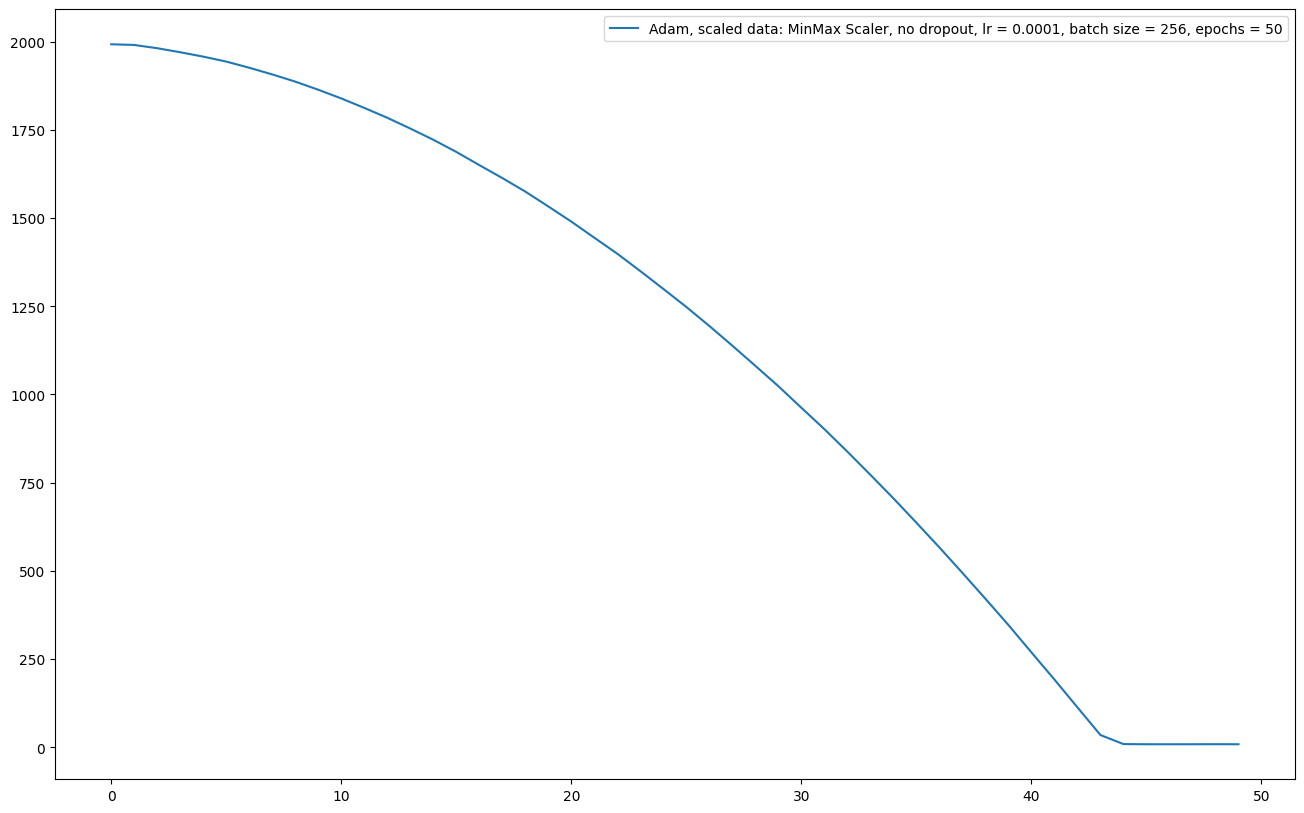

In [ ]:
plot([('Adam, scaled data: MinMax Scaler, no dropout, lr = 0.0001, batch size = 256, epochs = 50', valid_loss_values)])

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

# **Краткий вывод:**
Было сделано очень много попыток, начала путаться в собственной тетрадке, поэтому было принято решение удалить самые первые результаты.

Из того что мне помогло - это нормализация батча, в некоторых случаях масштабирование не с помощью Standard Scaler, а с помощью MinMax, а также добавление промежуточного нейронного слоя, кроме того помогали гиперпараметры в оптимизаторе. В SGD (momentum, Nesterov), В Adam (betas, eps). Dropout, к сожалению, не сильно помог, скорее вызывал переобучение, поэтому часто я его просто комментила. Какие-то эксперименты провела на GPU, какие-то на CPU, надеюсь, это не сильно повлияет на результат. Не включила результат, но еще помогло послепенное снижение learning_rate, так как я могла проанализировать результаты и понять, какой шаг лучше выставить.

# **Результат попытки №1**

https://www.geeksforgeeks.org/how-to-choose-batch-size-and-number-of-epochs-when-fitting-a-model/

В этой ссылке я смотрела про батчи, кол-во эпох. По умолчанию batch_size = 256.
Кол-во эпох = 50.
На geek рекомендуется протестировать несколько значений batch_size (например, 16, 32, 64, 128, 256).

learning_rate = 0.001

2 hidden_size скрытых слоя по 30.

input_size = 90 (входной слой)

output_size = 1 (выходной слой)

epochs = 50

Использование масштабировани данных - Standard Scaler.
Использование нормализации батча.
Функция активации - ReLU

Оптимизатор - SGD (parameters: momentum=0.9, nesterov=True)

Результат:
EPOCH 50, train_loss: 8.564851976914648, valid_loss: 8.476096748125435


# **Результат попытки №1.1**

input_size (входной слой) = 90

hidden_size (скрытый слой) = 30

hidden_size_2 (скрытый слой) = 30

Два промежуточных нейронных слоя.

output_size = 1

batch_size = 256
epochs = 55
learning_rate = 0.1

Масштабирование - Standard Scaler
- имеется нормализация батча
- добавлены dropout на 2 слоя. (dropout = 0.2)
- Функция активации - ReLU

optimizer - SGD(parameters:learning_rate)

Результат: EPOCH 55, train_loss: 173.08589094048304, valid_loss: 14.974342454778085

Модель переобучилась, как только закомментила drop_out результат был лучше.



# **Результат попытки №1.2**



input_size = 90 #входной слой

hidden_size = 30 # размер скрытого слоя

hidden_size_2 = 30 # размер скрытого

output size =1

batch_size = 256 # размер матрицы, которая лежит в X

epochs = 50 #сколько раз мы прогоним нашу модель за все обучение

learning_rate = 0.001

Масштабирование данных - MinMax Scaler
Модель:

- Нет dropout
- нормализация батча
- ReLU

optimizer = SGD(parameters: learning_rate, momentum = 0.9, nesterov=True)
Результат: EPOCH 50, train_loss: 8.859761294676504, valid_loss: 8.591843250954506



# **Результат попытки №2**

input_size (входной слой) = 90

hidden_size (скрытый слой) = 45

hidden_size_2 (скрытый слой) = 45

Два промежуточных нейронных слоя.

output_size = 1

batch_size = 256
epochs = 50
learning_rate = 0.0001

Масштабирование - Standard Scaler
- имеется нормализация батча
- нет dropout
- Функция активации - ReLU

optimizer - Adam(parameters:learning_rate, betas=(0.9, 0.999), eps=1e-08)


Результат: EPOCH 50, train_loss: 8.567155282228988, valid_loss: 8.553186862775595


# **Результат попытки №2.1**

input_size (входной слой) = 90

hidden_size (скрытый слой) = 45

hidden_size_2 (скрытый слой) = 45

Два промежуточных нейронных слоя.

output_size = 1

batch_size = 256

 epochs = 50

learning_rate = 0.0001

Масштабирование - MinMax Scaler

Модель:

- имеется нормализация батча
- нет dropout
- Функция активации - ReLU
- optimizer - Adam(parameters:learning_rate, betas=(0.9, 0.999), eps=1e-08)

Результат: EPOCH 50, train_loss: 8.810142337618021, valid_loss: 8.63560423992648


# **C dropout:**

Все те же самые характристики, только теперь модель:

имеется нормализация батча
- dropout (0.2) на два слоя
- Функция активации - ReLU
- optimizer - Adam(parameters:learning_rate, eps=1e-08)

Результат: EPOCH 50, train_loss: 148.4228360973973, valid_loss: 15.928611354072496

Модель переобучилась.


# **Результат попытки №3**

input_size (входной слой) = 90

hidden_size (скрытый слой) = 90

hidden_size_2 (скрытый слой) = 30

hidden_size_3 = 30

Три промежуточных нейронных слоя.

output_size = 1

batch_size = 256

epochs = 50

learning_rate = 0.0001

Масштабирование - MinMax Scaler

Модель:

- имеется нормализация батча
- нет dropout
- Функция активации - ReLU
- optimizer - AdamW(parameters:learning_rate, betas=(0.9, 0.999), eps=1e-08)

Результат: EPOCH 50, train_loss: 8.670765858612313, valid_loss: 8.566180104076272


# **Результат попытки 3.1**

input_size (входной слой) = 90

hidden_size (скрытый слой) = 90

hidden_size_2 (скрытый слой) = 30

hidden_size_3 = 30

Три промежуточных нейронных слоя.

output_size = 1

batch_size = 256

epochs = 50

learning_rate = 0.0001

Масштабирование - Standard Scaler

Модель:

- имеется нормализация батча
- нет dropout
- Функция активации - ReLU

optimizer - AdamW(parameters:learning_rate)

Результат: EPOCH 50, train_loss: 8.27896315688329, valid_loss: 8.566023902137681




# **Результат попытки №4**

input_size = 90 #входной слой

hidden_size = 120 # размер первого скрытого слоя

output_size = 1 # размер вызодного слоя

batch_size = 256 # установлю значение по рекомендованным

epochs = 100 #сколько раз мы прогоним нашу модель за все обучение

learning_rate = 0.001

Масштабирование - MinMax Scaler

Модель:

- не имеется нормализация батча
- нет dropout
- Функция активации - ReLU

optimizer - AdamW(parameters:learning_rate)

Результат: EPOCH 100, train_loss: 10.301590940020732, valid_loss: 9.951478493095625


# **Результат попытки №5**



input_size = 90 #входной слой

hidden_size_1 = 90

hidden_size_2 = 30 # размер первого скрытого слоя

hidden_size_3 = 30 # размер второго скрытого слоя

output_size = 1 # размер вызодного слоя

batch_size = 256 # установлю значение по рекомендованным

epochs = 50 #сколько раз мы прогоним нашу модель за все обучение

learning_rate = 0.0001

Масштабирование - MinMax Scaler

Модель:

- имеется нормализация батча
- нет dropout
- Функция активации - ReLU

optimizer - AdamW(parameters:learning_rate)

Результат: EPOCH 50, train_loss: 8.667202356898494, valid_loss: 8.59967595043749